## カメラキャリブレーション 練習用プログラム

In [44]:
# ===== 関数 =====
def plotCamera(ax, R, t, c, scale):
    ps_c = np.array(([0,0,0], [1,1,3], [1,-1,3], [-1,-1,3], [-1,1,3]))
    ps_w = np.zeros((ps_c.shape))

    for i_p in range(ps_c.shape[0]):
        ps_w[i_p] = R.dot(scale*ps_c[i_p]) + t

    L01 = np.array([ps_w[0], ps_w[1]])
    L02 = np.array([ps_w[0], ps_w[2]])
    L03 = np.array([ps_w[0], ps_w[3]])
    L04 = np.array([ps_w[0], ps_w[4]])
    L1234 = np.array([ps_w[1], ps_w[2], ps_w[3], ps_w[4], ps_w[1]])
    
    ax.plot(L01[:,0], L01[:,1], L01[:,2], "-", color=c)
    ax.plot(L02[:,0], L02[:,1], L02[:,2], "-", color=c)
    ax.plot(L03[:,0], L03[:,1], L03[:,2], "-", color=c)
    ax.plot(L04[:,0], L04[:,1], L04[:,2], "-", color=c)
    ax.plot(L1234[:,0], L1234[:,1], L1234[:,2], "-", color=c)


内部行列 ：  [[1.32931637e+03 0.00000000e+00 9.57857318e+02]
 [0.00000000e+00 1.32931637e+03 5.47353253e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
歪みパラメータ :  [[ 0.0052289  -0.01161532  0.0029297   0.00017352  0.0003208 ]]


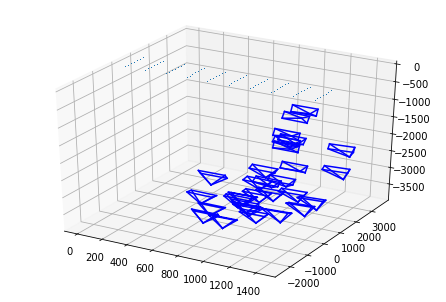

In [52]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ===== キャリブレーション用設定パラメータ =====
row = 7 # チェスパターンのコーナーの行数
col = 10 # チェスパターンのコーナーの列数
size = 160 # チェスパターンのコーナー間の距離
data_dir = "./data" # キャリブレーション用画像のデータフォルダ
suffix = "png" # キャリブレーション用画像の拡張子
# =================================

corner_num = (col, row) # チェスパターンのコーナーの数

pW = np.empty([row * col, 3], dtype=np.float32)
for i_row in range(0, row):
    for i_col in range(0, col):
        pW[i_row*col+i_col] = np.array([size*i_col, size*i_row, 0], dtype=np.float32)

pWs = []
qIs = []

glob_string = "%s/*.%s" % (data_dir, suffix) 

for image_path in glob(glob_string): # 入力画像のリスト
    image = cv2.imread(image_path, 0)
    found, qI = cv2.findChessboardCorners(image, corner_num) # チェスコーナーの検出

    if found:# コーナー検出成功
        term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        qI_sub = cv2.cornerSubPix(image, qI, (5,5), (-1,-1), term) # サブピクセル精度でコーナー位置を推定
        pWs.append(pW)
        qIs.append(qI_sub)       
    else: #コーナー検出失敗
        print("Detection failed :", image_path)
        continue 

# 内部キャリブレーション
rep, K, d, rvec, tvec = cv2.calibrateCamera(pWs, qIs, (image.shape[1], image.shape[0]), None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

# 内部パラメータ
print("内部行列 ： ", K)
print("歪みパラメータ : ", d)

# 結果のプロット
plot_mode = 1 # 0: カメラ固定， 1: チェスボード固定
fig = plt.figure()
ax = Axes3D(fig)

if plot_mode == 0: # カメラ固定．　カメラ座標系で描画
    
    plotCamera(ax, np.eye(3), np.zeros((1,3)), "b", 100) # カメラの描画＠原点
    
    for i_ex in range(len(rvec)):
        pC = np.zeros((pW.shape))
        for i_p in range(pW.shape[0]):
            R_w2c = cv2.Rodrigues(rvec[i_ex])[0]
            t_w2c = tvec[i_ex].reshape(3)
            pC[i_p,:] = R_w2c.dot(pW[i_p,:]) + t_w2c # 世界座標系からカメラ座標系に変換
    
        ax.plot(pC[:,0], pC[:,1], pC[:,2], ".") # チェスボードの描画
        
elif plot_mode == 1: # チェスボード固定．　チェスボード（世界）座標系で描画
    
    for i_ex in range(len(rvec)):
        R_c2w = np.linalg.inv(cv2.Rodrigues(rvec[i_ex])[0]) #　世界座標系におけるカメラの向き
        t_c2w = -R_c2w.dot(tvec[i_ex]).reshape((1,3)) # 世界座標系におけるカメラの位置
        
        plotCamera(ax, R_c2w, t_c2w, "b",100)

    ax.plot(pW[:,0], pW[:,1], pW[:,2], ",")
        